# AirBnb New User Bookings

* [AirBnb New User Bookings](#AirBnb-New-User-Bookings)
	* [Introduction](#Introduction)
	* [Data Description](#Data-Description)
	* [Evaluation method](#Evaluation-method)
	* [Data Preprocessing](#Data-Preprocessing)
		* [Data Exploration](#Data-Exploration)
			* [Unbalanced Variables](#Unbalanced-Variables)
			* [Missing Values](#Missing-Values)
			* [Continuous Variables and Outliers](#Continuous-Variables-and-Outliers)
		* [Data Aggregation](#Data-Aggregation)
		* [Cleaning and Feature Engeneering](#Cleaning-and-Feature-Engeneering)
	* [Building a model](#Building-a-model)
		* [Data portioning](#Data-portioning)
		* [Cross Validation Results](#Cross-Validation-Results)
	* [Evaluation](#Evaluation)
		* [Model Performance for Different Classes](#Model-Performance-for-Different-Classes)
		* [Comparison with Simple Decision rules: Random and Fixed](#Comparison-with-Simple-Decision-rules:-Random-and-Fixed)
		* [Two step classification problem](#Two-step-classification-problem)
			* [Classification Report for each Class](#Classification-Report-for-each-Class)
			* [Test Hypotheses about Class Ranks](#Test-Hypotheses-about-Class-Ranks)
		* [Feature Importance](#Feature-Importance)
	* [Summary](#Summary)


## Introduction

New users on Airbnb can book a place to stay in 34,000+ cities across 190+ countries. By accurately predicting where a new user will book their first travel experience, Airbnb can share more personalized content with their community, decrease the average time to first booking, and better forecast demand.

As a part of [Kaggle competition](https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings) AirBnb provided a list of users along with their demographics, web session records, and some summary statistics. The goal of the project was to predict in which country a new user will make his or her first booking.

Described solution got 160th place being in top 11% among all participants and got 0.88484 score on unseen test data, profile can be found [here](https://www.kaggle.com/tmakarova). 

## Data Description

There are 12 possible outcomes of the destination country: &#39;US&#39;, &#39;FR&#39;, &#39;CA&#39;, &#39;GB&#39;, &#39;ES&#39;, &#39;IT&#39;, &#39;PT&#39;, &#39;NL&#39;,&#39;DE&#39;, &#39;AU&#39;, &#39;NDF&#39; (no destination found), and &#39;other&#39;. The training and test sets are split by dates. Test data set is used for submissions in competition. Test data set contains all users with first activities after  **7/1/2014**. In the sessions dataset, the data only dates back to 1/1/2014, while the users dataset dates back to 2010.

In total, there are 4 data files provided for training:
- User data file contain information about 213451 users and 15 features including target variable. Features describe the user (age, gender), devices and applications she uses and etc.
- Session data file is the biggest among all provided files (nearly 600 Mb) and contain information about web session records for users. In total, it has 10567737 records and 6 features.
- Other two files (countries and age_gender_bkts) contain some information about countries (geographical information, language) and distribution of age - gender groups in different countries.

## Evaluation method

The goal was to predict five most probable destinations for the user. Performance was evaluated by Normalized Discounted Cumulative Gain (NDCG), which measures the performance of a recommendation system based on the graded relevance of the recommended entities. It varies from 0.0 to 1.0, with 1.0 representing the ideal ranking of the entities. Some details on the metric can be found [here](https://en.wikipedia.org/wiki/Discounted_cumulative_gain#Normalized_DCG) .

During evaluation of an algorithm on some test data set, NDCG is calculated for each test observation and than all values are averaged in order to generate one score value.

## Data Preprocessing 

### Data Exploration

In this section we will perform very brief data exploration in order to highlight important characteristics of underlying data.

In [1]:
import warnings

In [43]:
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append("../")
import ModelValidation.utils as mv_utils 


% matplotlib inline
warnings.filterwarnings('ignore') 


In [3]:
users = pd.read_csv("../data/users.csv")
sessions = pd.read_csv("../data/sessions.csv")

#### Unbalanced Variables

Target variable _country destination_ is highly unbalanced, most cases correspond to either NDF class (no booking) or US (travel whithin US).

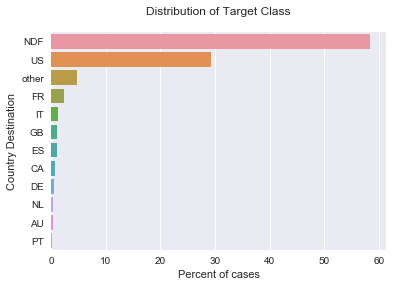

In [4]:
counts_dest = users.country_destination.value_counts(dropna=False)
perc_dest = 100 * counts_dest/users.shape[0]
ax = sns.barplot(y=perc_dest.index, x=perc_dest.values)
ax.set_ylabel("Country Destination")
ax.set_xlabel("Percent of cases")
ax.set_title("Distribution of Target Class\n")

Number of cases and percent in each target class

In [5]:
pd.DataFrame({"# cases" : counts_dest.apply(lambda v : "%d" % v), "% cases" : perc_dest}).transpose()

,NDF,US,other,FR,IT,GB,ES,CA,DE,NL,AU,PT
# cases,124543,62376,10094,5023,2835,2324,2249,1428,1061,762,539,217
% cases,58.3473,29.2226,4.72895,2.35323,1.32817,1.08877,1.05364,0.669006,0.49707,0.356991,0.252517,0.101663


Target variable country_destination is quite unbalanced. Most cases (nearly 60%) correspons to 'NDF' - situation when booking was not made. The second destination is 'US' - nearly 30 % of all trainig cases. This means that only 10% of cases corresponds to other destinations, where 5% relates to not listed destination ('other' group).

Some categorical features are also unbalanced. In the following chart each dot correspond to the level of categorical feature, on the x-axis percent of cases corresponding to the level are shown.  

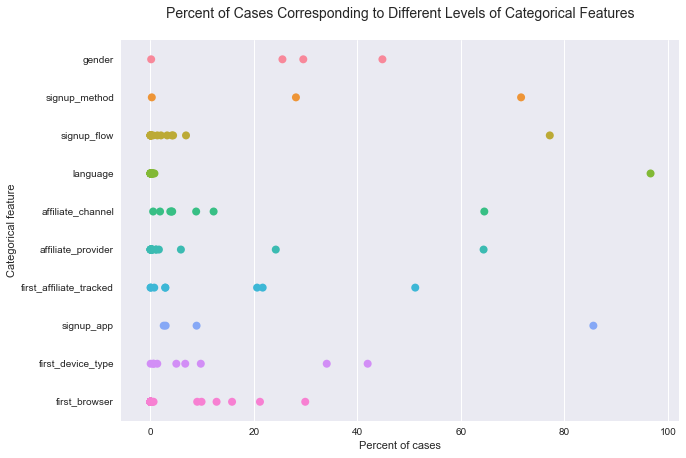

In [6]:
excl_vars = ["id","age", "date_account_created", "date_first_active", \
             "timestamp_first_active", "date_first_booking", "country_destination"]
fields_stat = mv_utils.get_levels_stat(users, excl_vars)

fig, ax = plt.subplots(figsize=(10,7))
sns.stripplot(y="field", x="perc", data=fields_stat, size=8, ax=ax)
ax.set_xlabel("Percent of cases")
ax.set_ylabel("Categorical feature")
ax.set_title("Percent of Cases Corresponding to Different Levels of Categorical Features\n", \
            fontsize=14)

For example, _language_ variable has 25 levels, but more than 97% correspond to English ('en').

Next we consider level distribution for session categorical variables.

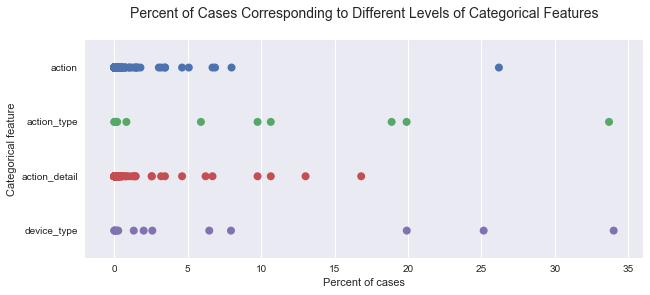

In [7]:
ses_fields_stat = mv_utils.get_levels_stat(sessions, ["user_id", "secs_elapsed"])

fig, ax = plt.subplots(figsize=(10,4))
sns.stripplot(y="field", x="perc", data=ses_fields_stat, size=8, ax=ax)
ax.set_xlabel("Percent of cases")
ax.set_ylabel("Categorical feature")
ax.set_title("Percent of Cases Corresponding to Different Levels of Categorical Features\n", \
            fontsize=14)

Unbalance of target variable can make prediction of rare classes quite difficult. One solution is try to resample cases for rare classes and therefor increase presence of these classes in the data. It can help to make rare classes more noticeable for classification algorithm. 

We started with initial data distribution without resampling. We have tried to introduce some groupings for levels of categorical variables (in order to make them more balanced), however, this did not improve model performance, so in final solution no groupings was used.

#### Missing Values

Percent of missed cases for categorical features in users and sessions data sets (including categories like "unknown")

In [8]:
not_specified_levels = ["-unknown-", "untracked", "other/unknown", "unknown", "nan"]
print "Missing values in users data set\n" + "*"*40
print fields_stat[fields_stat.level.str.lower().isin(not_specified_levels) | fields_stat.level.isnull()] \
                .groupby("field").perc.sum()
print "\nMissing values in sessions data set\n" + "*"*40
print ses_fields_stat[ses_fields_stat.level.str.lower().isin(not_specified_levels) | ses_fields_stat.level.isnull()] \
                .groupby("field").perc.sum()

Missing values in users data set
****************************************
field
first_affiliate_tracked    54.015676
first_browser              12.773892
first_device_type           4.997400
gender                     44.829024
Name: perc, dtype: float64

Missing values in sessions data set
****************************************
field
action            0.753482
action_detail    20.414446
action_type      20.414721
device_type       1.999283
Name: perc, dtype: float64


Percent of missed cases for  continuous and date features in users and sessions data sets

In [9]:
100 * users[["age", "date_account_created", "timestamp_first_active" ]].isnull().sum() / users.shape[0]

age                       41.222576
date_account_created       0.000000
timestamp_first_active     0.000000
dtype: float64

In [10]:
100 * sessions[["secs_elapsed"]].isnull().sum() / users.shape[0]

secs_elapsed    63.729381
dtype: float64

A large part of age and gender data is missed, in nearly 45* of cases gender is not specified and in 41% of cases age is missed. Considering action variables, variables 'action' is presented for most cases, but 'action_detail' and 'action_type' can be missed (nearly in 20% of cases, considering them separately)   

####  Continuous Variables and Outliers

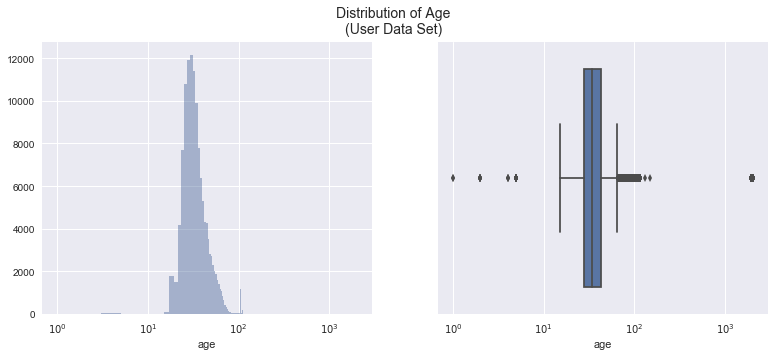

In [11]:
keep = (users.age.notnull()) 
fig, ax = plt.subplots(1,2, figsize=(13,5))
ax[0].set_xscale('log')
ax[1].set_xscale('log')
sns.distplot(users[keep].age, ax=ax[0], bins=1000, kde=False, color= sns.xkcd_rgb["denim blue"])
sns.boxplot('age', data=users[keep], ax=ax[1])
fig.suptitle("Distribution of Age\n(User Data Set)\n", fontsize=14)

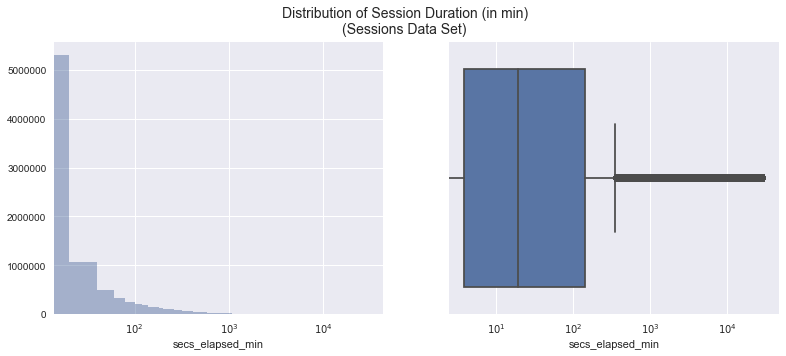

In [12]:
sessions["secs_elapsed_min"] = sessions.secs_elapsed / 60.
keep = (sessions.secs_elapsed_min.notnull()) 
fig, ax = plt.subplots(1,2, figsize=(13,5))
ax[0].set_xscale('log')
ax[1].set_xscale('log')
sns.distplot(sessions[keep].secs_elapsed_min, ax=ax[0], bins=1500, kde=False, color= sns.xkcd_rgb["denim blue"])
sns.boxplot('secs_elapsed_min', data=sessions[keep], ax=ax[1])
fig.suptitle("Distribution of Session Duration (in min)\n(Sessions Data Set)\n", fontsize=14)

Age variable contain some improper values: too small or too large, these values should be filtered out. Note that some large age values can be a "wrong input" when data of birth is used instead of age. Session duration also have some large outliers, however there is no obvious reason for filtering.

We will remove ages less than 14 and greater than 95 (replace with null values). Since we are going to use decision trees which are quite robust to outliers, we will not preprocess and filter outliers from security duration variable. 

### Data Aggregation

Session actions are presented in 3 variables. However, considering them separately often does not clarify what user actually did and if it could be important.

For example, there is a _action_ : personalize with _action-type_ : data. However, variable _action-detail_ is very clear - wishlist\_content\_update, which is definitely can be an action which users who made a booking performed.

We combine all three variables in one aggregated variable _aggr-action_ of specified format.

For each _aggr-action_ we will define a short name (agg\_action\_number). We will create a table with full and short names for actions. Giving number for each action we will order them by percent of users, who used that action (agg\_action\_0 is the most common action among users). This kind of renaming is not important for the algorithm, but can be useful for further exploration and interpretation.

In total there are 467 unique aggregated actions. Some part of these actions were used quite rarely by the users.

We will add some simple classification of actions mostly to exclude those which were rarely used. All actions which were used by less than 1% of users were combined in special &quot;other&quot; group (called &quot;agg\_action\_other&quot;). However, some rarely used actions could still be related to booking activity. In order not to lose this information, actions from &quot;other&quot; group were further combined if they contained the same key\_word (called &quot;agg\_action\_other\_[key\_word]&quot;). A simple list of key words were used: [&quot;host&quot;, &quot;book&quot;, &quot;wishlist&quot;, &quot;reserv&quot;, &quot;transl&quot;, &quot;coupon&quot;].

Note that all actions which were used by more than 1% of users, were not grouped in any way.  After grouping there were 150 unique action groups. Note that use of 1% threshold is quite arbitrary and can be reconsidered in further analysis.

Pivot sessions dataset and merge it with users data by user\_id field. As a result, in combined dataset for each user\_id there are:

- 15 variable coming from users data (age, gender, etc);
- 150 actions (coded aggregated and grouped) with corresponding number of uses (number of sessions). If a user did not perform an action, value is set to NaN.
- 14 types of devices with corresponding number of uses (number of sessions). If a user did not use specific type of device, value is set to NaN.
- Total duration of all sessions for a user
- Total number of actions

In total, combined dataset has 213451 lines (users) and 182 variables.

Note that, only around 35% of users have session data. It is not clear how to impute missing data for all other users and if it makes sense at all. This fact imposes certain restrictions on the choice of classification algorithm.

### Cleaning and Feature Engeneering

Simple basic cleaning was performed. 

- Date account created was transformed into three variables : year, date, month;
- Date first active was transformed into three variables : year, date, month;
- Session duration is transformed into days
- Action variables are transformed to percentages – percentage of times when specific action was performed by the user
- Clean age variable and remove age below 14 and over 95.
- Fill Na values with -1


## Building a model

Note that, only around 35% of users have session data. It is not clear how to impute missing data for all other users and if it makes sense at all. This fact imposes certain restrictions on the choice of classification algorithm.

Decision trees are known be good in handling data of mixed type with outliers and data with missing values. Decision trees are also known to have often weaker predictive power in comparison with some other algorithms. However, using of various ensemble methods (like boosting or random forest) can significantly improve predictive power. 

We will use Gradient Boosted Trees (GBT) and Random Forest (RF) for multiclass classification. 

### Data portioning

We randomly split the data into two groups: train and evaluation (90% and 10%). Train part is used for model training and optimization of parameters with cross validation. During cross validation part of the data is used for training and part of the data is used for evaluation, so that model performance is always estimated on unseen data. Cross validation has a few iterations when data is split in different ways, at the end scores can be averaged and give single performance estimation.

Once models and parameters are selected, they can be trained on the whole train data and applied to untouched evaluation data part. Evaluation step is important in order to provide estimate about model performance in real conditions.


### Cross Validation Results

In [13]:
xgb_parvar = pd.read_csv("../ModelValidation/xgb_parvar_add.csv")
rf_parvar = pd.read_csv("../ModelValidation/rf_parvar.csv")

For GBT three parameters were considered for tuning: number of estimators, learning rate and tree depth. 

First for fixed tree depth (equal to 6) learning rate and number of estimators were varied in ranges:
 * learning rate : 0.1, 0.15, 0.2, 0.3
 * number of estimators: 20, 25, 30:10:100
 
 Once best learning rate and number of estimators were fixed, a few values of tree depth were considerd:
 * tree depth: 3, 6, 8, 10 

Next results of 3-fold cross validation on training data set are presented

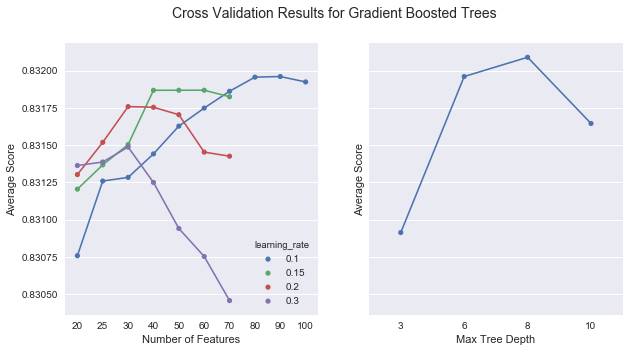

In [42]:
fig, ax = plt.subplots(1,2, figsize=(10,5), sharey=True)
colormap = plt.cm.gist_ncar
plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, 3)])

sns.set_style("darkgrid")
sns.pointplot(x="n_estimators", y="score", data=xgb_parvar[xgb_parvar.max_depth==6],
              hue="learning_rate", scale=0.5, ax=ax[0])
sns.pointplot(x="max_depth", y="score", data=xgb_parvar[(xgb_parvar.n_estimators==90) &
                                (xgb_parvar.learning_rate==0.1)], scale=0.5, ax=ax[1])

fig.suptitle("Cross Validation Results for Gradient Boosted Trees\n", fontsize=14)
ax[0].set_ylabel("Average Score")
ax[0].set_xlabel("Number of Features")
ax[1].set_ylabel("Average Score")
ax[1].set_xlabel("Max Tree Depth")


Learning rates 0.1 and 0.15 with number of estimators greater or equal to 40 outperformed other model runs. 
Pair (0.1, 90) was selected as the best option from performed calculatiom, note that it is quite stable and performance in close neighborhood almost doest not change. Next, for fixed pair of learning rate and number of estimators I calculated a few values of tree depth and selected max_deapth = 8 as optimal.

This two step procedure was performed only because of computational issues, since it takes time to calculated a lot of model runs.

For Random Forest Model two parameters were considered:
 * number of estimators : 100, 200, 300, 400
 * number of features : 15, 50, 100, 150


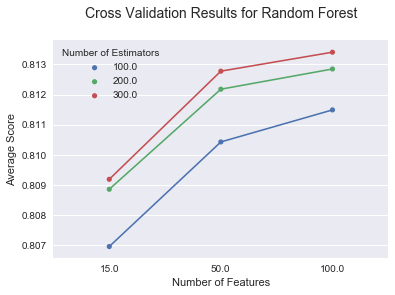

In [38]:
ax = sns.pointplot(x="max_features", y="score", data=rf_parvar, hue="n_estimators", scale=0.5)
ax.set_title("Cross Validation Results for Random Forest\n", fontsize=14)
ax.set_ylabel("Average Score")
ax.set_xlabel("Number of Features")
plt.legend(title="Number of Estimators")

As a final model GBM with 0.1 learning rate, 90 estimators and tree depth of 8 will be used. Please note that selected here parameters differ a little bit from those used in Kaggle competition (0.15 learning rate, 40 estimators and 8 max tree depth).

## Evaluation

After cross validation GBM was selected and then it was run on the whole train set, trained classifier was applied to unseen evaluation data set.

In [16]:
eval_res = pd.read_csv("../evaluations/eval_clf_md8.csv")

In [17]:
eval_res.ndcg_5.mean()

0.83331260022685094

The model had nearly 0.833 score on evaluation data set, which is quite close to cross validation results.

### Model Performance for Different Classes

Next chart and table shows average score for each value of true class. NDCG score value measures relevance of top 5 ranked predictions to the true class value. 

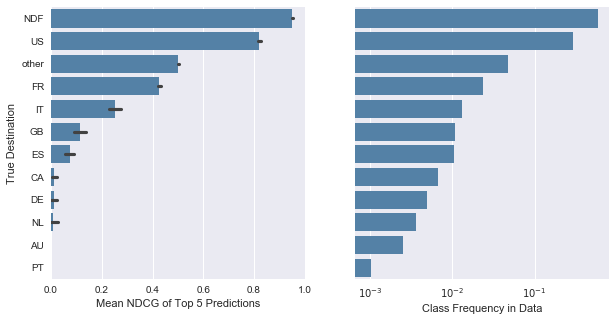

In [18]:
v = eval_res.groupby("true_destination").ndcg_5.mean()
v.sort(ascending=False)
classes_dist = users.country_destination.value_counts(normalize=True)

fig, ax = plt.subplots(1,2, figsize=(10,5), sharey=True)
ax[1].set_xscale('log')
sns.barplot(y="true_destination", x="ndcg_5", data=eval_res, order=v.index, color="steelblue", ax=ax[0])
sns.barplot(y=classes_dist.index, x=classes_dist.values, color="steelblue", ax=ax[1])
ax[0].set_ylabel("True Destination")
ax[0].set_xlabel("Mean NDCG of Top 5 Predictions")
ax[1].set_xlabel("Class Frequency in Data")


In [19]:
classes_dist.name = "classes_frequencies"
pd.concat([v.to_frame(), classes_dist.to_frame()], axis=1 ) \
                    .transpose().sort_values("ndcg_5", axis=1, ascending=False)

,NDF,US,other,FR,IT,ES,GB,CA,DE,AU,NL,PT
ndcg_5,0.950206,0.821756,0.500852,0.427165,0.252902,0.114766,0.073671,0.012184,0.010647,0.008789,0.00000,0.000000
classes_frequencies,0.583473,0.292226,0.047290,0.023532,0.013282,0.010536,0.010888,0.006690,0.004971,0.002525,0.00357,0.001017


We can see that for NDF ans US classes classification model gives more relevant results than for other classes. We can also note that relevance score decreases as decrease presence of a class in the data. Rare classes can have very low or even zero (they were not predicted in top 5) average relevance.

In accordance with this observation, we can consider the following questions:
 * Is the model smarter that some naive decision rules? 
   Next we will consider two decision rules: 
     * Random decision. Top 5 classes are randomly sampled from all classes in accordance with classes frequencies in the train data set. After that selected 5 classes are ranked in accordance with frequencies.
     * Fixed decision. Top 5 classes are always predicted as 5 most frequent classes according to the train data set.
     
     
 * We can separate classification problem into two parts: 
     * Define if a user made any booking or not (NDF vs non-NDF)
     * If the user made booking, predict country destination
     
   The question is if model works efficiently in both parts of the problem. We see that model works better for NDF and US classes, does that mean that it can predict only if user made a booking or not.

### Comparison with Simple Decision rules: Random and Fixed

Next we will consider two simple decision rules and compare them with the model. 
First we will consider random decision. Top 5 classes are randomly sampled from all classes in accordance with classes frequencies in the train data set. After that selected 5 classes are ranked in accordance with frequencies.
Next we will consider fixed decision. Top 5 classes are always predicted as 5 most frequent classes according to the train data set.

The question is if the model outperforms simple decision rules.

In [20]:
eval_rnd = mv_utils.get_rnd_eval("mean_rnd_df.csv", eval_res)
v_rnd = eval_rnd.groupby("true_destination").mean_rnd_score.mean()
v_rnd = v_rnd.sort_values(ascending=False)

Load from mean_rnd_df.csv


In [21]:
eval_fixed = mv_utils.get_fixed_eval(classes_dist.index, eval_res)
v_fixed = eval_fixed.groupby("true_destination").ndcg_5.mean()
v_fixed = v_fixed.sort_values(ascending=False)

In [22]:
df = pd.concat([v, v_rnd, v_fixed], axis=1)
df.columns = ["model", "rnd decision", "fixed decision"]
df = df.sort_values("model", ascending=False).transpose()
df["score"] = [eval_res.ndcg_5.mean(), eval_rnd.mean_rnd_score.mean(), eval_fixed.ndcg_5.mean()]
df

,NDF,US,other,FR,IT,ES,GB,CA,DE,AU,NL,PT,score
model,0.950206,0.821756,0.500852,0.427165,0.252902,0.114766,0.073671,0.012184,0.010647,0.008789,0.000000,0.000000,0.833313
rnd decision,0.999787,0.629405,0.408748,0.260460,0.163682,0.124764,0.132657,0.081181,0.060354,0.029432,0.044462,0.011992,0.798150
fixed decision,1.000000,0.630930,0.500000,0.430677,0.386853,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.806038


From the table above we can see that model outperforms random decision and fixed decision (see score column which corresponds to average NDCG score for all cases in evaluation data set). Considering classes separately, we see that model gives slightly worse score for NDF class (because by definition random and fixed decisions give more preference to NDF class), but for US class it outperforms other variants. However, for all other classes model is the same or worse than considered simple decision rules.

In [23]:
melted_df = pd.melt(df.iloc[:,:-1].transpose().reset_index(), id_vars=["index"], \
                    value_vars=["model", "rnd decision", "fixed decision"])
melted_df.columns = ["Country Destination", "Decision", "Score"]

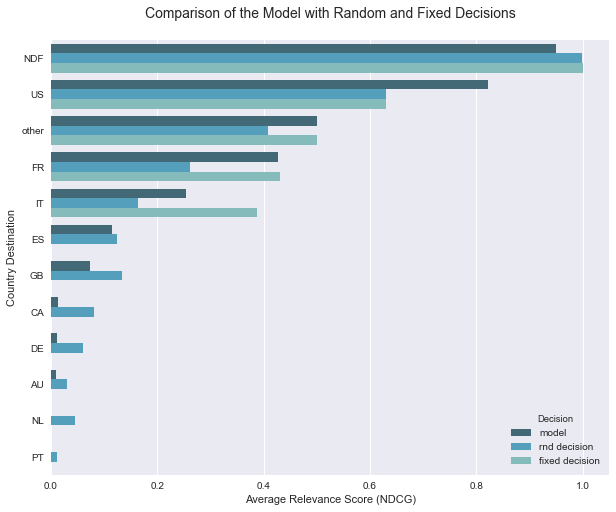

In [24]:
fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(y="Country Destination", x="Score", hue="Decision", data=melted_df, ax=ax, orient="h", palette="GnBu_d")
ax.set_title("Comparison of the Model with Random and Fixed Decisions\n", fontsize=14)
ax.set_xlabel("Average Relevance Score (NDCG)")



### Two step classification problem

We can separate classification problem into two parts:

 * Define if a user made any booking or not (NDF vs non-NDF)
 * If the user made booking, predict country destination

The question is if model works efficiently in both parts of the problem. We see that model works better for NDF and US classes, does that mean that it can predict only "booking" and "not booking" events?.

#### Classification Report for each Class 

Next we will consider standard classification report which compares true and predicted values of a class. Since it considers only one value as class prediction (not a list of predictions), we will use prediction with highest probability. 

In [25]:
from sklearn.metrics import classification_report
print classification_report(eval_res.true_destination, eval_res.pred_0)

             precision    recall  f1-score   support

         AU       0.00      0.00      0.00        49
         CA       0.00      0.00      0.00       127
         DE       0.00      0.00      0.00       109
         ES       0.00      0.00      0.00       235
         FR       0.00      0.00      0.00       510
         GB       0.00      0.00      0.00       247
         IT       0.00      0.00      0.00       269
        NDF       0.71      0.87      0.78     12434
         NL       0.00      0.00      0.00        83
         PT       0.00      0.00      0.00        20
         US       0.52      0.52      0.52      6236
      other       0.00      0.00      0.00      1027

avg / total       0.57      0.66      0.61     21346



Considering only one best prediction, we can see that model predicted only NDF and US classes. For NDF class model shows more or less high recall and precision, meaning that model is able to identity "user did not make booking" situations. Among all users who did not make booking (NDF class) model identified 87% correctly (recall = 87%), among all users with predicted class "NDF" 71% did not make booking (precision = 71%). Note that fixed decision, when NDF is always predicted, gives 100% recall, but only 58% precision (frequency of NDF in data).

Class "US" is likely to be "made booking" prediction rather than prediction of certain destination.

#### Test Hypotheses about Class Ranks

We'd like to understand whether model is capable to predict concrete destination rather than "booking" and "not booking" cases. 

For each case in evaluation data set we will consider position (rank) of correct prediction in the list of predicted classes. List of predicted classes is formed based on prediction probabilities defined by the model. 

For NDF class we will consider the following hypotheses:
 * H0: There is no difference in position of NDF class in ranked list of predictions in situations when booking was made and when booking was not made;
 * H1: Position of NDF class in ranked list of predictions is higher in situation when booking was not made.
    
For a classes 'A' corresponding to specific destination we will consider the following hypotheses:
 * H0: There is no difference in position of 'A' class in ranked list of predictions in situations when 'A' destination was booked and when other destination was booked (latter assumes that booking was made, but with other country destination);
 * H1: Position of 'A' class in ranked list of predictions is higher in situation when 'A' destination was booked.
 
Next we will perform Mann-Whitney rank test and calculate effect sizes based on Common language effect size and Rank-biserial correlation.

We will also consider these hypotheses in terms of average ranks and perform t-test. 

Note that in technical implementation we consider ranks from 0 to num_classes-1, where rank=0 means most probable prediction. Therefor rank decrease actually means "good" situation when class become more probable in comparison with other classes.

In [26]:
class_labels = eval_res.true_destination.unique()
ranks = pd.DataFrame(map(lambda row: [list(row).index(cl) for cl in class_labels ], eval_res.iloc[:,:-2].values),
             columns = class_labels)
ranks["true_destination"] = eval_res["true_destination"]

In [27]:
mannwhit = mv_utils.perform_rank_test(ranks)
mannwhit = mannwhit.sort_values("pval")

In [28]:
ttest = mv_utils.perform_ttest(ranks)
ttest = ttest.sort_values("cohen_d", ascending=False)

Below are results of Mann-Whitney rank test with Common language effect size (clez) and Rank-biserial correlation (rb_corr).

In [29]:
mannwhit[mannwhit.country_destination == 'NDF']

,country_destination,smpl1_size,smpl2_size,stat,pval,clez,rb_corr
1,NDF,12434.0,8912.0,34232426.5,0.0,0.448269,0.382152


For NDF class we can reject Null hypothesis in favor of alternative, position of NDF class in ranked list of predictions is significantly higher (rank is significantly lower) in situation when booking was not made in comparison with situation when booking was made.

Next we consider comparison of average ranks and test hypothesis if average ranks are equal. Below are results of t-test and Cohen`s D effect size (cohen_d).

In [30]:
ttest[ttest.country_destination == "NDF"]

,country_destination,smpl1_size,smpl2_size,avg_rank1,avg_rank2,stat,pval,cohen_d
1,NDF,12434.0,8912.0,0.135918,0.547352,-65.302507,0.0,0.871369


T-test shows significant difference between average ranks with large effect size.

Next we will consider different country destination and run Mann-Whitney rank tests as well as t-test for average ranks. Note that we perform multiple tests here. If we want to pick out classes which have significantly different ranks, than we have to perform some correction of significance level used for each individual model, for example, Bonferroni correction. 

Below are results of Mann-Whitney rank test and t-test for different destination classes. In the following two tables classes where significant decrease in ranks (or average ranks) was detected are highlighted with green, significance level was adjusted to the number of performed tests.

In [31]:
def highlight_rows(s):
    return ['background-color: #CCFFE5' if i in np.where(mannwhit.pval<0.05/11)[0] else '' for i in range(len(s))]
mannwhit[mannwhit.country_destination != 'NDF'].style.apply(highlight_rows)

Table above shows results of Mann-Whitney rank test along with Common language effect size (clez) and Rank-biserial correlation (rb_corr). For 7 classes significant decrease was detected, but effect sizes are rather small. It is interesting to note that for 'US' class, which is a dominant class among all destination classes, no significant decrease in ranks was detected.

In [32]:
def highlight_rows(s):
    return ['background-color: #CCFFE5' if i in np.where(ttest.pval<0.05/11)[0] else '' for i in range(len(s))]
ttest[ttest.country_destination != "NDF"].style.apply(highlight_rows)

Table above shows results of t-test and Cohen`s D effect size (cohen_d). For 7 classes significant decrease was detected, list of classes is almost the same as for previous test (the only difference is that 'other' class was replaced with 'DE'). Effect sizes are medium or small. Again for 'US' class no significant decrease in average rank was detected.

Although for 7 classes change in ranks (average ranks) are significantly different, we can see that for most cases it is not enough to move the class to the top 5 predictions. 

Performed analysis showed that suggested model is quite weak in prediction of country destination and is rather focused on prediction of "booking" and "not booking" events.

### Feature Importance

In this section we will consider which features are considered to be most important by the model. Next two charts show top 10 features ranked by their performance. Feature importance was defined by two methods. In the left chart importance of a feature was estimated according to the number of times this feature was used in tree splits. In the right chart importance of feature was estimated by considering not just the number of splits, but average gain associated splits. 

In [33]:
import pickle

with open("../ModelValidation/dev/clf_md8.pkl") as infile:
    fitted_clf = pickle.load(infile)
with open("../ModelValidation/dev/features_md8.pkl") as infile:
    features = pickle.load(infile)

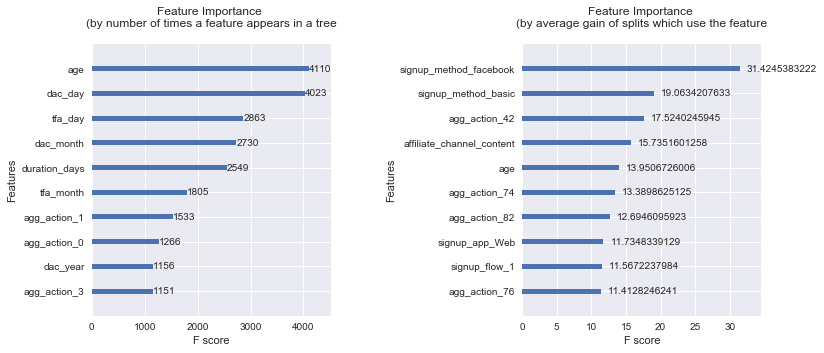

In [34]:
mv_utils.plot_importance(fitted_clf, features, 10)

Note that different methods of importance estimation give different top features. From the left chart we see that, for example, day, month, year of account creation or first activity are considered to be important by the model. Probably, algorithm tried to catch some seasonality in the data. Age variable is considered important by both methods. From the right char, we can see that signup method and content of affiliate channel are important.  

In the next two tables we list all actions from top10 important features. First table contains actions from the left chart and second - from the right. 

In [35]:
actions = pd.read_csv("../data/agg_action_info.csv")

In [52]:
a1 = actions.loc[actions.agg_action_code_gr.isin(flabels1),["agg_action_code_gr", "aggr_action"]]
a1["importance_rank"] = a1.agg_action_code_gr.apply(lambda s: (len(flabels1) - flabels1.index(s)))
a1.sort_values(by="importance_rank")

,agg_action_code_gr,aggr_action,importance_rank
8,agg_action_1,|a|header_userpic|t|data|d|header_userpic,7
7,agg_action_0,|a|show|t|view|d|p3,8
2,agg_action_3,|a|personalize|t|data|d|wishlist_content_update,10


In [53]:
a1 = actions.loc[actions.agg_action_code_gr.isin(flabels2),["agg_action_code_gr", "aggr_action"]]
a1["importance_rank"] = a1.agg_action_code_gr.apply(lambda s: (len(flabels2) - flabels2.index(s)))
a1.sort_values(by="importance_rank")

,agg_action_code_gr,aggr_action,importance_rank
24,agg_action_42,|a|pending|t|booking_request|d|pending,3
98,agg_action_74,|a|manage_listing|t|view|d|manage_listing,6
93,agg_action_82,|a|at_checkpoint|t|booking_request|d|at_checkp...,7
99,agg_action_76,|a|set_user|t|submit|d|create_listing,10


It is reasonable to see that such actions like "wishlist_content_update" and "booking_request" are considered important. 

## Summary

In this project AirBnb data containing information about users from 2010 and web session records from 1/1/2014 was analyzed. The goal of the project was to predict in which country a new user will make his or her first booking. There were 12 possible outcomes for destination variable including "did not make any booking" situation.

Since for each user there were a history of web session records, some specific data aggregation was needed.
After aggregation data was cleaned briefly without addition of significant changes to the data. As a final algorithm Gradient Boosted Decision Trees was used. Available data was separated on train and evaluation data sets. Parameter optimization was performed on train part with cross validation, while model evaluation and analysis was performed on evaluation data set.

Trained model with optimized parameters got performance score on evaluation data close to that on cross validation step. 

Detailed analysis of the model revealed that it is more focused on prediction of the fact whether user made booking or not rather than on prediction of specific country destination. 

Possible future work:

 * Separate classification into two parts and develop two classification models, one for prediction of "booking" and "not booking" classes and one for prediction of country destination (assuming that booking was made).
 * Try different resampling schemes in order to increase influence of rare classes
 * Use provided information about countries (distance, language distance) and age - gender distributions. 
 * Since day, month, year of account creation and first activity were considered important by the model, construct some seasonality variables. 


## References

https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test#Common_language_effect_size

https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test#Rank-biserial_correlation

https://en.wikipedia.org/wiki/Bonferroni_correction